# IRI forecasts

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import rioxarray
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read in IRI data

In [3]:
data_dir = Path("data/INDIA/")
paths = list((data_dir / "iri_asia_all_tifs").iterdir())
sorted(paths)

[PosixPath('data/INDIA/iri_asia_all_tifs/iridlprecipitation_201808-201810.tiff'),
 PosixPath('data/INDIA/iri_asia_all_tifs/iridlprecipitation_201809_201811.tiff'),
 PosixPath('data/INDIA/iri_asia_all_tifs/iridlprecipitation_201810_201812.tiff'),
 PosixPath('data/INDIA/iri_asia_all_tifs/iridlprecipitation_201811_201901.tiff'),
 PosixPath('data/INDIA/iri_asia_all_tifs/iridlprecipitation_201812_201902.tiff'),
 PosixPath('data/INDIA/iri_asia_all_tifs/iridlprecipitation_201901_201903.tiff'),
 PosixPath('data/INDIA/iri_asia_all_tifs/iridlprecipitation_201902_201904.tiff'),
 PosixPath('data/INDIA/iri_asia_all_tifs/iridlprecipitation_201903_201905.tiff'),
 PosixPath('data/INDIA/iri_asia_all_tifs/iridlprecipitation_201904_201906.tiff'),
 PosixPath('data/INDIA/iri_asia_all_tifs/iridlprecipitation_201905_201907.tiff'),
 PosixPath('data/INDIA/iri_asia_all_tifs/iridlprecipitation_201906_201908.tiff'),
 PosixPath('data/INDIA/iri_asia_all_tifs/iridlprecipitation_201907_201909.tiff'),
 PosixPath('data

In [4]:
def read_iri_tiff(filepath: Path, include_cumulative_horizon: bool = False) -> xr.Dataset:
    # open the data
    ds = rioxarray.open_rasterio(filepath)
    da = ds.rename({"y": "lat", "x": "lon"}).isel(band=0).drop(['band', 'spatial_ref'])
    
    # get time data and variable from the string
    var = str(filepath).split("/")[-1].split("_")[0]
    var = var.split('dl')[-1]
    
    init_date_str = str(filepath).split("/")[-1].split("_")[1:]
    if len(init_date_str) == 1:
        init_date_str = init_date_str[0].split('-')[0]
        end_date_str = init_date_str[0].split('-')[-1]
    else:
        init_date_str = init_date_str[0]
        end_date_str = init_date_str[-1]
    init_date = pd.to_datetime(init_date_str, format="%Y%m")
    var = "_".join(var.split('dl'))
    
    # create new datarray
    if not include_cumulative_horizon:
        data = da.data[..., np.newaxis]
        coords = dict(lat=da.lat, lon=da.lon, initialisation_date=[init_date])
    else:
        data = da.data[..., np.newaxis, np.newaxis]
        coords = dict(lat=da.lat, lon=da.lon, initialisation_date=[init_date], cumulative_horizon=[3])

    dims = [d for d in coords.keys()]
    out_da = xr.DataArray(data, dims=dims, coords=coords)
    out_da.name = var

    return out_da.to_dataset()


def read_all_iri_paths(iri_dir: Path, include_cumulative_horizon: bool = False) -> xr.Dataset:
    paths = list(iri_dir.iterdir())
    das = [read_iri_tiff(path, include_cumulative_horizon) for path in paths]
    ds = xr.auto_combine(das, concat_dim='initialisation_date')
    if include_cumulative_horizon:
        ds = ds.transpose("initialisation_date", "lat", "lon", "cumulative_horizon")
    else:
        ds = ds.transpose("initialisation_date", "lat", "lon")
    
    ds = ds.sortby(["initialisation_date", "lat", "lon"])
    
    return ds

In [5]:
ds = read_all_iri_paths(data_dir / "iri_asia_all_tifs", include_cumulative_horizon=False)
ds

<xarray.Dataset>
Dimensions:              (initialisation_date: 28, lat: 86, lon: 131)
Coordinates:
  * lat                  (lat) float64 -10.0 -9.0 -8.0 -7.0 ... 73.0 74.0 75.0
  * lon                  (lon) float64 40.0 41.0 42.0 43.0 ... 168.0 169.0 170.0
  * initialisation_date  (initialisation_date) datetime64[ns] 2018-08-01 ... 2020-11-01
Data variables:
    precipitation        (initialisation_date, lat, lon) float32 36.987534 ... nan

# Plot the data

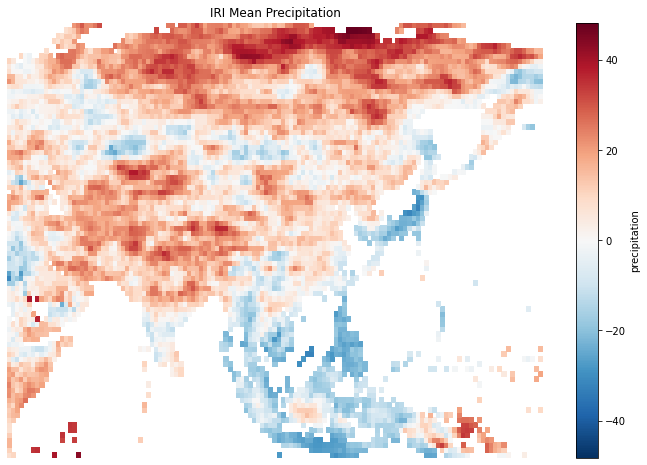

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
ds.precipitation.mean(dim='initialisation_date').plot(ax=ax)
ax.set_title("IRI Mean Precipitation")
ax.axis('off');

# Read in Vegetation Data

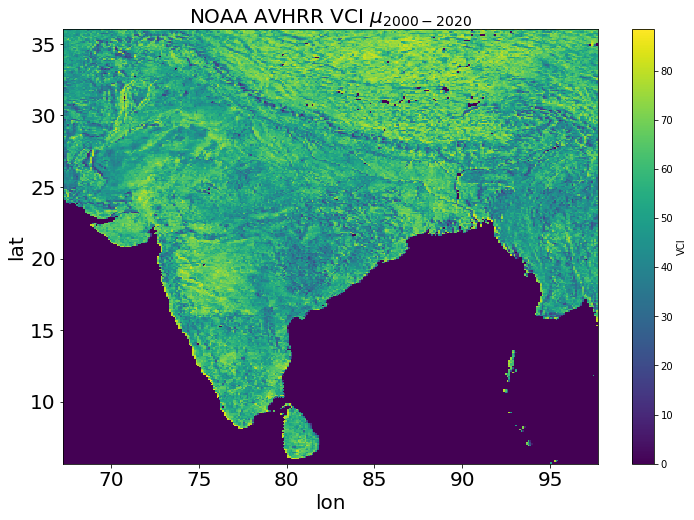

In [7]:
vci = xr.open_dataset(data_dir / "data_india.nc")
# vci = xr.open_dataset(data_dir / "data_india.nc_")

fig, ax = plt.subplots(figsize=(12, 8))
vci["VCI"].mean(dim='time').plot(ax=ax)
ax.set_title("NOAA AVHRR VCI $\mu_{2000-2020}$");

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)


In [8]:
vci

<xarray.Dataset>
Dimensions:  (lat: 304, lon: 305, time: 247)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2020-07-31
  * lon      (lon) float32 67.3 67.4 67.5 67.6 67.7 ... 97.3 97.4 97.5 97.6 97.7
  * lat      (lat) float32 36.0 35.9 35.8 35.7 35.6 35.5 ... 6.1 6.0 5.9 5.8 5.7
Data variables:
    VCI      (time, lat, lon) float64 75.97 67.77 47.63 40.73 ... nan nan nan

# Read in the ERA5 Land Data